# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.7207

947/947 [==============================] - 3538s 4s/step - loss: 0.8324 - accuracy: 0.7207 - val_loss: 0.8530 - val_accuracy: 0.7099
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.7541

947/947 [==============================] - 3250s 3s/step - loss: 0.7154 - accuracy: 0.7541 - val_loss: 0.7148 - val_accuracy: 0.7669
Epoch 3/200
947/947 [==============================] - 2980s 3s/step - loss: 0.6718 - accuracy: 0.7667 - val_loss: 2.7306 - val_accuracy: 0.6072
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.7772

947/947 [==============================] - 3263s 3s/step - loss: 0.6373 - accuracy: 0.7772 - val_loss: 0.6968 - val_accuracy: 0.7600
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7890

947/947 [==============================] - 3298s 3s/step - loss: 0.5981 - accuracy: 0.7890 - val_loss: 0.5906 - val_accuracy: 0.7930
Epoch 6/200
947/947 [==============================] - 2977s 3s/step - loss: 0.6185 - accuracy: 0.7866 - val_loss: 5.0369 - val_accuracy: 0.6469
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.8013

947/947 [==============================] - 3248s 3s/step - loss: 0.5611 - accuracy: 0.8013 - val_loss: 0.5810 - val_accuracy: 0.7976
Epoch 8/200
947/947 [==============================] - 2979s 3s/step - loss: 0.5482 - accuracy: 0.8068 - val_loss: 0.6585 - val_accuracy: 0.7813
Epoch 9/200
947/947 [==============================] - 2978s 3s/step - loss: 0.5362 - accuracy: 0.8093 - val_loss: 0.6695 - val_accuracy: 0.7896
Epoch 10/200
947/947 [==============================] - 2996s 3s/step - loss: 0.5113 - accuracy: 0.8193 - val_loss: 0.5956 - val_accuracy: 0.7962
Epoch 11/200
947/947 [==============================] - 2978s 3s/step - loss: 0.4946 - accuracy: 0.8240 - val_loss: 2.5381 - val_accuracy: 0.6027
Epoch 12/200
947/947 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8193

947/947 [==============================] - 3258s 3s/step - loss: 0.5143 - accuracy: 0.8193 - val_loss: 0.5735 - val_accuracy: 0.8040
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8326

947/947 [==============================] - 3257s 3s/step - loss: 0.4684 - accuracy: 0.8326 - val_loss: 0.5044 - val_accuracy: 0.8233
Epoch 14/200
947/947 [==============================] - 2981s 3s/step - loss: 0.4877 - accuracy: 0.8261 - val_loss: 0.5601 - val_accuracy: 0.8097
Epoch 15/200
947/947 [==============================] - 2981s 3s/step - loss: 0.4609 - accuracy: 0.8345 - val_loss: 0.7325 - val_accuracy: 0.7955
Epoch 16/200
947/947 [==============================] - 2976s 3s/step - loss: 0.4346 - accuracy: 0.8401 - val_loss: 0.5344 - val_accuracy: 0.8135
Epoch 17/200
947/947 [==============================] - 3031s 3s/step - loss: 0.4216 - accuracy: 0.8483 - val_loss: 0.5076 - val_accuracy: 0.8282
Epoch 18/200
947/947 [==============================] - 2977s 3s/step - loss: 0.4089 - accuracy: 0.8534 - val_loss: 0.5191 - val_accuracy: 0.8180
Epoch 19/200
947/947 [==============================] - 2975s 3s/step - loss: 0.3903 - accuracy: 0.8583 - val_loss: 0.5508 - val_accuracy

947/947 [==============================] - 3253s 3s/step - loss: 0.3864 - accuracy: 0.8584 - val_loss: 0.4746 - val_accuracy: 0.8334
Epoch 21/200
947/947 [==============================] - 2992s 3s/step - loss: 0.3760 - accuracy: 0.8630 - val_loss: 0.4913 - val_accuracy: 0.8342
Epoch 22/200
947/947 [==============================] - 2978s 3s/step - loss: 0.3691 - accuracy: 0.8646 - val_loss: 0.4939 - val_accuracy: 0.8276
Epoch 23/200
947/947 [==============================] - 2976s 3s/step - loss: 0.3494 - accuracy: 0.8716 - val_loss: 0.4942 - val_accuracy: 0.8288
Epoch 24/200
947/947 [==============================] - 2981s 3s/step - loss: 0.3313 - accuracy: 0.8794 - val_loss: 0.4998 - val_accuracy: 0.8234
Epoch 25/200
947/947 [==============================] - 2981s 3s/step - loss: 0.3196 - accuracy: 0.8828 - val_loss: 0.5244 - val_accuracy: 0.8187
Epoch 26/200
947/947 [==============================] - 2975s 3s/step - loss: 0.3099 - accuracy: 0.8851 - val_loss: 1.2876 - val_accuracy

947/947 [==============================] - 3251s 3s/step - loss: 0.3041 - accuracy: 0.8870 - val_loss: 0.4594 - val_accuracy: 0.8500
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8915

947/947 [==============================] - 3249s 3s/step - loss: 0.2933 - accuracy: 0.8915 - val_loss: 0.4562 - val_accuracy: 0.8484
Epoch 29/200
947/947 [==============================] - 2990s 3s/step - loss: 0.2781 - accuracy: 0.8983 - val_loss: 0.5185 - val_accuracy: 0.8345
Epoch 30/200
947/947 [==============================] - 2977s 3s/step - loss: 0.2657 - accuracy: 0.9004 - val_loss: 0.4700 - val_accuracy: 0.8456
Epoch 31/200
947/947 [==============================] - 2977s 3s/step - loss: 0.2587 - accuracy: 0.9038 - val_loss: 0.5434 - val_accuracy: 0.8316
Epoch 32/200
947/947 [==============================] - 2986s 3s/step - loss: 0.2631 - accuracy: 0.9033 - val_loss: 0.4873 - val_accuracy: 0.8435
Epoch 33/200
947/947 [==============================] - 2995s 3s/step - loss: 0.2441 - accuracy: 0.9093 - val_loss: 0.6007 - val_accuracy: 0.8205
Epoch 34/200
947/947 [==============================] - 2976s 3s/step - loss: 0.2311 - accuracy: 0.9143 - val_loss: 0.5033 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 315s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.984726682551193,
 'basal cell carcinoma': 0.9861159380549879,
 'dermatofibroma': 0.9903734982154526,
 'melanoma': 0.9411679831916994,
 'nevus': 0.9697452146369562,
 'pigmented benign keratosis': 0.9877986501221515,
 'seborrheic keratosis': 0.9630270092226614,
 'solar lentigo': 0.9563539938671894,
 'squamous cell carcinoma': 0.9801080634614723,
 'vascular lesion': 0.993509604913534}

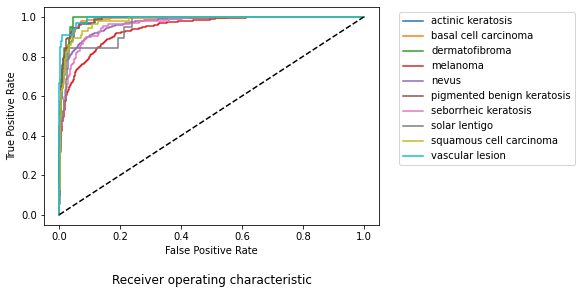

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

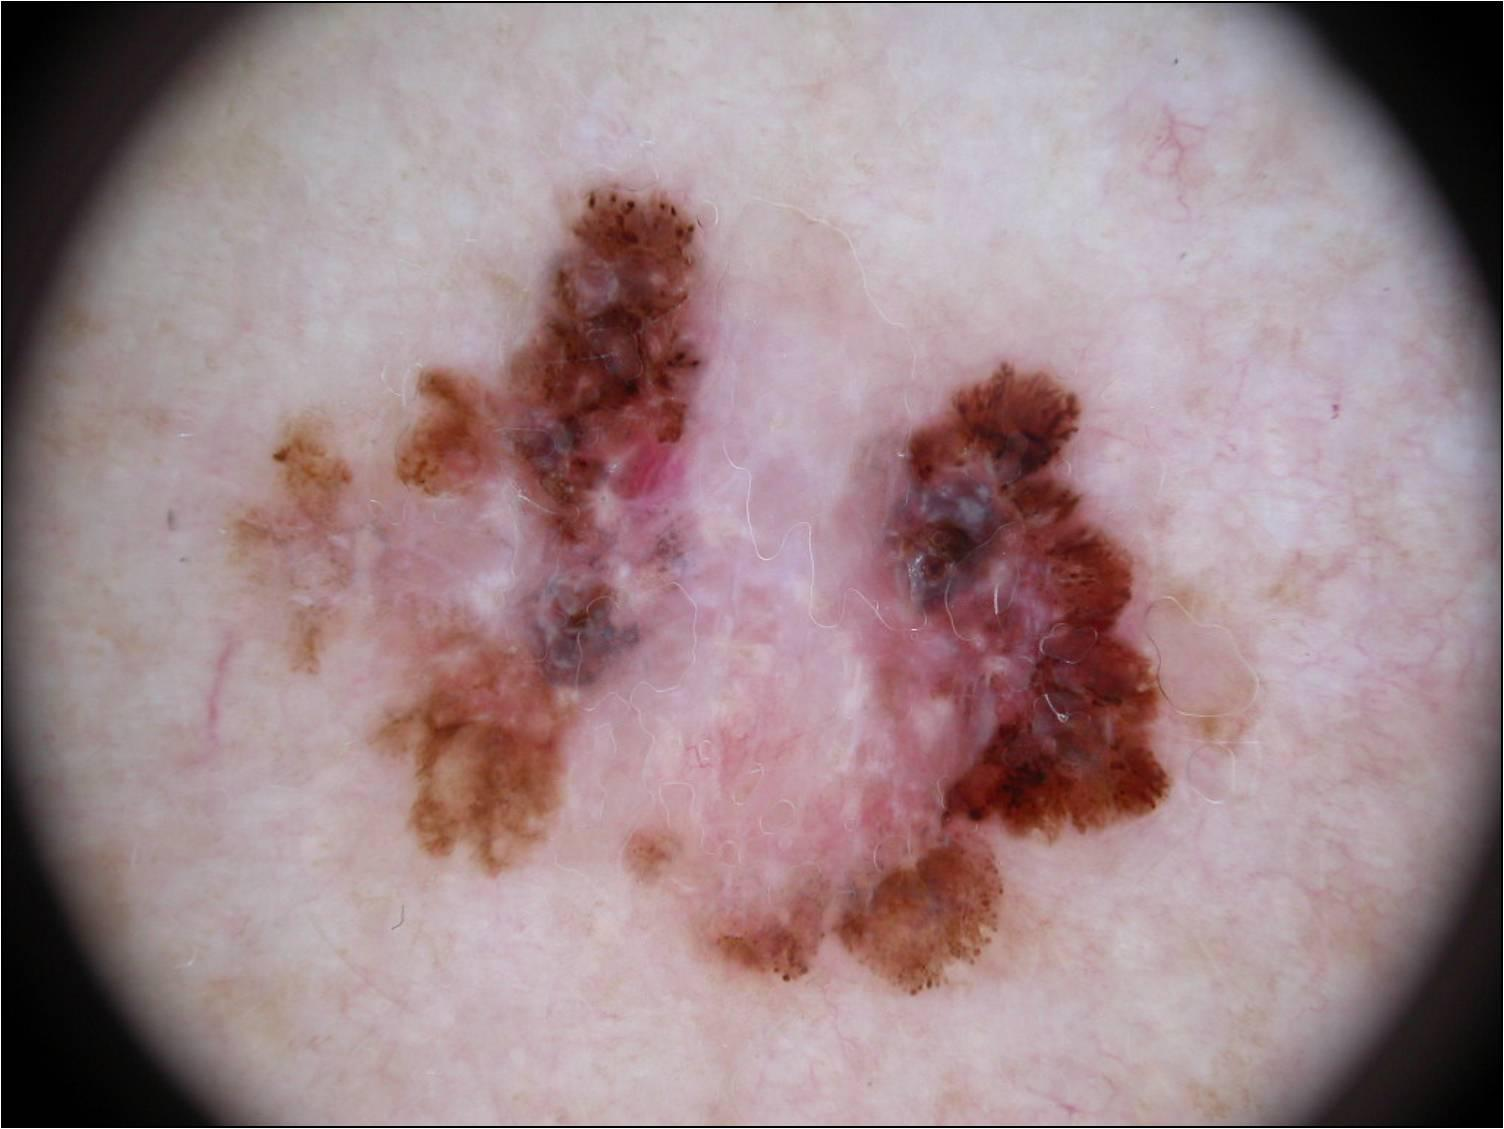

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

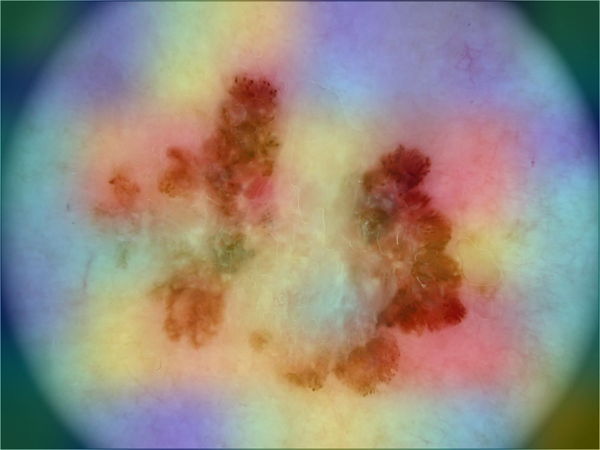

In [23]:
display_gradcam(melanoma_im_path, heatmap)